# Document Indexing and RAG



In this tutorial, we'll demonstrate how RAG operations can be implemented in Pixeltable. In particular, we'll develop a RAG application that summarizes a collection of PDF documents and uses ChatGPT to answer questions about them.

In a traditional RAG workflow, such operations might be implemented as a Python script that runs on a periodic schedule or in response to certain events. In Pixeltable, they are implemented as persistent tables that are updated automatically and incrementally as new data becomes available.

<div class="alert alert-block alert-info"><!-- mdx:none -->
<b>If you are running this tutorial in Colab:</b>
In order to make the tutorial run a bit snappier, let's switch to a GPU-equipped instance for this Colab session. To do that, click on the <code>Runtime -> Change runtime type</code> menu item at the top, then select the <code>GPU</code> radio button and click on <code>Save</code>.
</div>

We first set up our OpenAI API key:

In [1]:
import os
import getpass
if 'OPENAI_API_KEY' not in os.environ:
    os.environ['OPENAI_API_KEY'] = getpass.getpass('OpenAI API Key:')

We then install the packages we need for this tutorial and then set up our environment.

In [2]:
%pip install -q pixeltable sentence-transformers tiktoken openai openpyxl

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pixeltable as pxt

# Ensure a clean slate for the demo
pxt.drop_dir('rag_demo', force=True)
pxt.create_dir('rag_demo')

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/sergeymkhitaryan/.pixeltable/pgdata
Created directory 'rag_demo'.


Next we'll create a table containing the sample questions we want to answer. The questions are stored in an Excel spreadsheet, along with a set of "ground truth" answers to help evaluate our model pipeline. We can use `create_table()` with the `source` parameter to load them. Note that we can pass the URL of the spreadsheet directly.

In [4]:
base = 'https://github.com/pixeltable/pixeltable/raw/main/docs/resources/rag-demo/'
qa_url = base + 'Q-A-Rag.xlsx'
queries_t = pxt.create_table('rag_demo.queries', source=qa_url)

Created table 'queries'.
Inserting rows into `queries`: 8 rows [00:00, 2512.50 rows/s]
Inserted 8 rows with 0 errors.


In [5]:
queries_t.head()

S__No_,Question,correct_answer
1,What is roughly the current mortage rate?,0.07
2,What is the current dividend yield for Alphabet Inc. (\$GOOGL)?,0.0046
3,What is the market capitalization of Alphabet?,\$2182.8 Billion
4,What are the latest financial metrics for Accenture PLC?,missed consensus forecasts and strong total bookings rising by 22% annually
5,What is the overall latest rating for Amazon.com from analysts?,SELL
6,What is the operating cash flow of Amazon in Q1 2024?,"18,989 Million"
7,What is the expected EPS for Nvidia in Q1 2026?,0.73 EPS
8,What are the main reasons to buy Nvidia?,"Datacenter, GPUs Demands, Self-driving, and cash-flow"


## Outline

There are two major parts to our RAG application:

1. Document Indexing: Load the documents, split them into chunks, and index them using a vector embedding.
2. Querying: For each question on our list, do a top-k lookup for the most relevant chunks, use them to construct a ChatGPT prompt, and send the enriched prompt to an LLM.

We'll implement both parts in Pixeltable.

## Document Indexing

All data in Pixeltable, including documents, resides in tables.

Tables are persistent containers that can serve as the store of record for your data. Since we are starting from scratch, we will start with an empty table `rag_demo.documents` with a single column, `document`.

In [6]:
documents_t = pxt.create_table(
    'rag_demo.documents',
    {'document': pxt.Document}
)

documents_t

Created table 'documents'.


table 'rag_demo.documents'

 Column Name      Type Computed With
    document  Document

Next, we'll insert our first few source documents into the new table. We'll leave the rest for later, in order to show how to update the indexed document base incrementally.

In [7]:
document_urls = [
    base + 'Argus-Market-Digest-June-2024.pdf',
    base + 'Argus-Market-Watch-June-2024.pdf',
    base + 'Company-Research-Alphabet.pdf',
    base + 'Jefferson-Amazon.pdf',
    base + 'Mclean-Equity-Alphabet.pdf',
    base + 'Zacks-Nvidia-Report.pdf',
]

Inserting rows into `documents`: 3 rows [00:00, 388.95 rows/s]
Inserted 3 rows with 0 errors.


document
""
""
""

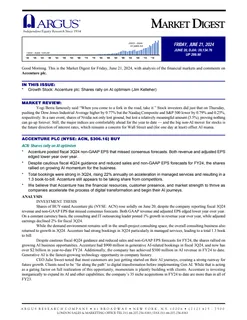
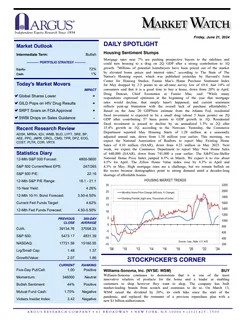
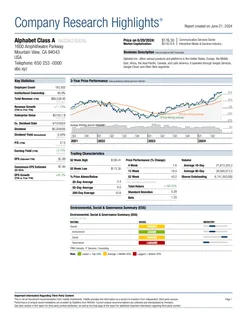

In [8]:
documents_t.insert({'document': url} for url in document_urls[:3])
documents_t.show()

In RAG applications, we often decompose documents into smaller units, or chunks, rather than treating each document as a single entity. In this example, we'll use Pixeltable's built-in `DocumentSplitter`, but in general the chunking methodology is highly customizable. `DocumentSplitter` has a variety of options for controlling the chunking behavior, and it's also possible to replace it entirely with a user-defined iterator (or an adapter for a third-party document splitter).

In Pixeltable, operations such as chunking can be automated by creating **views** of the base `documents` table. A view is a virtual derived table: rather than adding data directly to the view, we define it via a computation over the base table. In this example, the view is defined by iteration over the chunks of a `DocumentSplitter`.

In [9]:
from pixeltable.iterators import DocumentSplitter

chunks_t = pxt.create_view(
    'rag_demo.chunks',
    documents_t,
    iterator=DocumentSplitter.create(
        document=documents_t.document,
        separators='token_limit',
        limit=300
    )
)

Inserting rows into `chunks`: 41 rows [00:00, 24200.18 rows/s]


Our `chunks` view now has 3 columns:

In [10]:
chunks_t

view 'rag_demo.chunks' (of 'rag_demo.documents')

 Column Name              Type Computed With
         pos     Required[Int]              
        text  Required[String]              
    document          Document

- `text` is the chunk text produced by the `DocumentSplitter`
- `pos` is a system-generated integer column, starting at 0, that provides a sequence number for each row
- `document`, which is simply the `document` column from the base table `documents`. We won't need it here, but having access to the base table's columns (in effect a parent-child join) can be quite useful.

Notice that as soon as we created it, `chunks` was automatically populated with data from the existing documents in our base table. We can select the first 2 chunks from each document using common query operations, in order to get a feel for what was extracted:

pos,text,document
0,"MARKET DIGEST - 1 - FRIDAY, JUNE 21, 2024 JUNE 20, DJIA: 39,134.76 UP 299.90 Independent Equity Research Since 1934 ARGUS A R G U S R E S E A R C H C O M P A N Y • 6 1 B R O A D W A Y • N E W Y O R K , N. Y. 1 0 0 0 6 • ( 2 1 2 ) 4 2 5 - 7 5 0 0 LONDON SALES & MARKETING OFFICE TEL 011-44-207-256-8383 / FAX 011-44-207-256-8363 ® Good Morning. This is the Market Digest for Friday, June 21, 2024, with analysis of the financial markets and comments on Accenture plc. IN THIS ISSUE: * Growth Stock: Accenture plc: Shares rally on AI optimism (Jim Kelleher) MARKET REVIEW: Yogi Berra famously said ""When you come to a fork in the road, take it."" Stock investors did just that on Thursday, pushing the Dow Jones Industrial Average higher by 0.77% but the Nasdaq Composite and S&P 500 lower by 0.79% and 0.25%,",
1,"respectively. In a rare event, shares of Nvidia not only lost ground, but lost a relatively meaningful amount (3.5%), proving nothing can go up forever. Still, the major indices are comfortably ahead for the year to date — and the big non-AI mover for stocks is the future direction of interest rates, which remains a concern for Wall Street and (for one day at least) offset AI mania. ACCENTURE PLC (NYSE: ACN, \$306.16) BUY ACN: Shares rally on AI optimism * Accenture posted fiscal 3Q24 non-GAA ...... Q24, rising 22% annually on acceleration in managed services and resulting in a 1.3 book-to-bill. Accenture still appears to be taking share from competitors. * We believe that Accenture has the financial resources, customer presence, and market strength to thrive as companies accelerate the process of digital transformation and begin their AI journeys. ANALYSIS INVESTMENT THESIS Shares of BUY-rated Accenture plc (NYSE: ACN) rose solidly on June 20, despite the company reporting fiscal 3Q24",
0,"Friday, June 21, 2024 Intermediate Term: Market Outlook Bullish -------------- PORTFOLIO STRATEGY ------------- Equity: 72% Cash: 1% Today's Market Movers IMPACT aGlobal Shares Lower GILD Pops on HIV Drug Results SRPT Soars on FDA Approval SWBI Drops on Sales Guidance + + + - a a a Recent Research Review ADSK, MRNA, IQV, WMB, BUD, LYFT, SRE, BP, AEE, PPC, JNPR, ORCL, CMG, TPR, DPZ, EOG, COST, PLTR, COR, VRTX Statistics Diary 12-Mth S&P 500 Forcast: S&P 500 Current/Next EPS: S&P 500 P/E: 12-Mth S&P P/E Range: 10-Year Yield: 12-Mth 10-Yr. Bond Forecast: Current Fed Funds Target: 12-Mth Fed Funds Forecast: 4800-5600 247/265 22.16 18.1 - 21.1 4.26% 3.50-4.50% 4.62% 4.50-5.50% DJIA: S&P 500: NASDAQ: Lrg/Small Cap: Growth/Value: PREVIOUS CLOSE 200-DAY AVERAGE 39134",
1,".76 37058.23 5473.17 4831.39 17721.59 15160.55 1.48 1.37 2.07 1.86 CURRENT RANKING Five-Day Put/Call: Momentum: Bullish Sentiment: Mutual Fund Cash: Vickers Insider Index: 1.00 Positive 346000 Neutral 44% Positive 1.70% Negative 3.42 Negative Housing Sentiment Slumps Mortgage rates near 7% are pushing prospective buyers to the sidelines and could turn housing to a drag on 2Q GDP after a strong contribution to 1Q growth. ""Millions of potential homebuyers have been priced out of the market ...... s published yesterday by Harvard's Joint Center for Housing Studies. Fannie Mae's Home Purchase Sentiment Index for May dropped by 2.5 points to an all-time survey low of 69.4. Just 14% of consumers said that it is a good time to buy a home, down from 20% in April. Doug Duncan, Chief Economist at Fannie Mae, said ""While many respondents expressed optimism at the beginning of the year that mortgage rates would decline, that simply hasn't happened, and current sentiment reflects pent-up",
0,"Company Research Highlights® Report created on June 21, 2024 This is not an investment recommendation from Fidelity Investments. Fidelity provides this information as a service to investors from independent, third-party sources. Performance of analyst recommendations are provided by StarMine from Refinitiv. Current analyst recommendations are collected and standardized by Investars. S
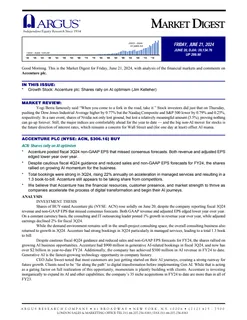
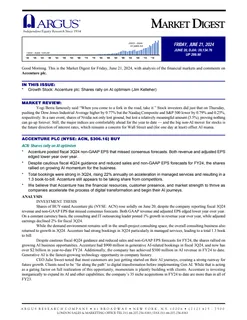
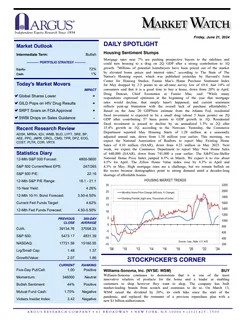
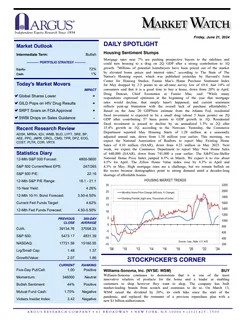
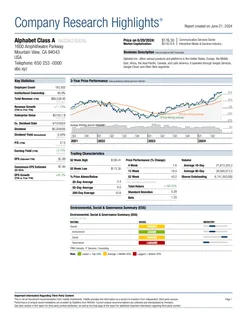
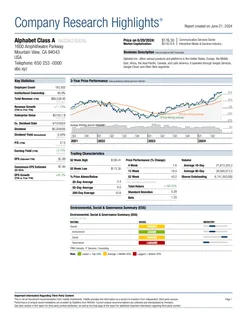

In [11]:
chunks_t.where(chunks_t.pos < 2).show()

Now let's compute vector embeddings for the document chunks and store them in a vector index. Pixeltable has built-in support for vector indexing using a variety of embedding model families, and it's easy for users to add new ones via UDFs. In this demo, we're going to use the E5 model from the Huggingface `sentence_transformers` library, which runs locally. 

The following command creates a vector index on the `text` column in the `chunks` table, using the E5 embedding model. (For details on index creation, see the [Embedding and Vector Indices](https://github.com/pixeltable/pixeltable/blob/release/docs/platform/embedding-indexes.ipynb) guide.) Note that defining the index is sufficient in order to load it with the existing data (and also to update it when the underlying data changes, as we'll see later).

In [12]:
from pixeltable.functions.huggingface import sentence_transformer

chunks_t.add_embedding_index(
    'text',
    embedding=sentence_transformer.using(model_id='intfloat/e5-large-v2')
)

This completes the first part of our application, creating an indexed document base. Next, we'll use it to run some queries.

## Querying

In order to express a top-k lookup against our index, we use Pixeltable's `similarity` operator in combination with the standard `order_by` and `limit` operations. Before building this into our application, let's run a sample query to make sure it works.

In [13]:
query_text = "What is the expected EPS for Nvidia in Q1 2026?"
sim = chunks_t.text.similarity(query_text)
nvidia_eps_query = (
    chunks_t
    .order_by(sim, asc=False)
    .select(similarity=sim, text=chunks_t.text)
    .limit(5)
)
nvidia_eps_query.collect()

similarity,text
0.799,"section in this report for third-party content attribution. Page 3 Report created on June 21, 2024 Recent Recap Last Report: Q1 Earnings on 04/25/24 Reported Earnings: \$1.89 per share Next Expected Report Date: 07/23/24 GOOGL exceeded the First Call Consensus of \$1.515 and exceeded the StarMine SmartEstimate from Refinitiv of \$1.533 for Q1 2024. About Starmine SmartEstimate The StarMine SmartEstimate from Refinitiv seeks to be more accurate than the consensus EPS by calculating an analyst's accuracy and timeliness of an analyst's estimates into its estimate of earnings. Actuals vs. Estimates by Fiscal Quarter Data provided by I/B/E/S from Refinitiv ACTUALS ESTIMATES STARMINE ESTIMATES GOOGL PRICE Earnings in US Dollars Q1 Q2 2024 Q1 Q2 Q3 Q4 2023 Q1 Q2 Q3 Q4 2022 \$0 \$100 \$200 Today 1.23 1.21 1.06 1.05 1.17 1.44 1.55 1.64 1.89 1.84 Actuals vs. Estimates for Fiscal Year First Call Estimates Actual"
0.797,"in this report for third-party content attribution and see page 4 for full disclosures. Page 2 Report created on June 21, 2024 Equity Summary Score is a weighted, aggregated view of opinions from the independent research firms on Fidelity.com. It uses the past accuracy of these firms in determining the emphasis placed on any individual opinion. First Call Consensus Recommendation is provided by I/B/E/S from Refinitiv, an independent third-party research provider, using information gathered ...... com for firm descriptions, detailed methodologies, and more information on the Equity Summary Score, First Call Consensus, opinion history and performance, and most current available research reports for GOOGL. Equity Summary Score (7 Firms†) Provided by StarMine from Refinitiv as of 6/21/2024 Firm1 Starmine Relative Accuracy2 Standardized Opinion3 Refinitiv/Verus (i) 30 Neutral Zacks Investment Research, Inc (i) 56 Outperform ISS-EVA (i) 86 Underperform Jefferson Research (i) 34 Buy Trading"
0.795,". Sometimes, being in the 100th percentile is not the best for items such as Debt to Capital Ratio where a lower number means less debt. Therefore, being in the 1st percentile indicates lower debt than its peers in the industry. The Industry Average is a market cap-weighted average of the non-null values in the industry.Company Research Highlights® NASDAQ GOOGL This is not an investment recommendation from Fidelity Investments. The information contained in this report is sourced from indepen ...... this report for third-party content attribution. © 2024 FMR LLC. All rights reserved. 447628.8.0 Page 4 Report created on June 21, 2024 Important Information Regarding Third-Party Content The content compiled in this report is provided by third parties and not Fidelity. Fidelity did not prepare and does not endorse such content. Historical prices provided by Datascope from Refinitiv. Fundamental data provided by Standard & Poor's Compustat®. Earnings estimates provided by Refinitiv. Analyst"
0.794,"Friday, June 21, 2024 Intermediate Term: Market Outlook Bullish -------------- PORTFOLIO STRATEGY ------------- Equity: 72% Cash: 1% Today's Market Movers IMPACT aGlobal Shares Lower GILD Pops on HIV Drug Results SRPT Soars on FDA Approval SWBI Drops on Sales Guidance + + + - a a a Recent Research Review ADSK, MRNA, IQV, WMB, BUD, LYFT, SRE, BP, AEE, PPC, JNPR, ORCL, CMG, TPR, DPZ, EOG, COST, PLTR, COR, VRTX Statistics Diary 12-Mth S&P 500 Forcast: S&P 500 Current/Next EPS: S&P 500 P/E: 12-Mth S&P P/E Range: 10-Year Yield: 12-Mth 10-Yr. Bond Forecast: Current Fed Funds Target: 12-Mth Fed Funds Forecast: 4800-5600 247/265 22.16 18.1 - 21.1 4.26% 3.50-4.50% 4.62% 4.50-5.50% DJIA: S&P 500: NASDAQ: Lrg/Small Cap: Growth/Value: PREVIOUS CLOSE 200-DAY AVERAGE 39134"
0.794,". 3. Each firm has its own recommendation categories, making it difficult to compare one firm's recommendation to another's. Investars, a third-party research company, collects and standardizes these recommendations using a five-point scale. † The Equity Summar

We perform this context retrieval for each row of our `queries` table by adding it as a computed column. In this case, the operation is a top-k similarity lookup against the data in the `chunks` table. To implement this operation, we'll use Pixeltable's `@query` decorator to enhance the capabilities of the `chunks` table.

In [14]:
# A @query is essentially a reusable, parameterized query that is attached to a table (or view),
# which is a modular way of getting data from that table.

@pxt.query
def top_k(query_text: str):
    sim = chunks_t.text.similarity(query_text)
    return (
        chunks_t.order_by(sim, asc=False)
            .select(chunks_t.text, sim=sim)
            .limit(5)
    )

# Now add a computed column to `queries_t`, calling the query
# `top_k` that we just defined.
queries_t.add_computed_column(
    question_context=top_k(queries_t.Question)
)

Added 8 column values with 0 errors.


8 rows updated, 8 values computed.

Our `queries` table now looks like this:

In [15]:
queries_t

table 'rag_demo.queries'

       Column Name    Type    Computed With
            S__No_     Int                 
          Question  String                 
    correct_answer  String                 
  question_context    Json  top_k(Question)

The new column `question_context` now contains the result of executing the query for each row, formatted as a list of dictionaries:

In [16]:
queries_t.select(queries_t.question_context).head(1)

question_context
"[{""sim"": 0.793, ""text"": "".76 37058.23\n5473.17 4831.39\n17721.59 15160.55\n1.48 1.37\n2.07 1.86\nCURRENT RANKING\nFive-Day Put/Call:\nMomentum:\nBullish Sentiment:\nMutual Fund Cas ...... sed optimism at the beginning of the year that mortgage \nrates would decline, that simply hasn't happened, and current sentiment \nreflects pent-up""}, {""sim"": 0.789, ""text"": "" frustration with the overall lack of purchase affordability.\"" \nBased on the June 20 GDPNow estimate from the Atlanta Fed, residential \nfixed inve ...... . High mortgage rates are a challenge, but we remain bullish on \nthe sector because demographics point to strong demand amid a decades-long \nshort""}, {""sim"": 0.775, ""text"": "" in this report for third-party content attribution and see page 4 for full disclosures.\nPage 2\nReport created on June 21, 2024\nEquity Summary Sco ...... \nRefinitiv/Verus (i) 30 Neutral\nZacks Investment Research, Inc (i) 56 Outperform\nISS-EVA (i) 86 Underperform\nJefferson Research (i) 34 Buy\nTrading""}, {""sim"": 0.773, ""text"": "". The content of this report \nmay be derived from Argus research reports, notes, or analyses. The opinions and information contained herein have b ...... all recipients of this report as \ncustomers simply by virtue of their receipt of this material. Investments involve risk and an investor may incur""}, {""sim"": 0.773, ""text"": ""Enterprise Value \$2103.1 B\n6/20/2024\nEx. Dividend Date 6/10/2024\nDividend \$0.200000\nDividend Yield (Annualized) 0.45%\n6/20/2024\nP/E (TTM) 27.0\n6/2 ...... 0.41\n52 Week Low\n7/11/2023\n\$115.35\n% Price Above/Below\n 20-Day Average 2.4\n 50-Day Average 6.0\n 200-Day Average 22.6\nPrice Performance (% Change)\n""}]"


### Asking the LLM

Now it's time for the final step in our application: feeding the document chunks and questions to an LLM for resolution. In this demo, we'll use OpenAI for this, but any other inference cloud or local model could be used instead.

We start by defining a UDF that takes a top-k list of context chunks and a question and turns them into a ChatGPT prompt.

In [17]:
# Define a UDF to create an LLM prompt given a top-k list of
# context chunks and a question.
@pxt.udf
def create_prompt(top_k_list: list[dict], question: str) -> str:
    concat_top_k = '\n\n'.join(
        elt['text'] for elt in reversed(top_k_list)
    )
    return f'''
    PASSAGES:

    {concat_top_k}

    QUESTION:

    {question}'''

We then add that again as a computed column to `queries`:

In [18]:
queries_t.add_computed_column(
    prompt=create_prompt(queries_t.question_context, queries_t.Question)
)

Added 8 column values with 0 errors.


8 rows updated, 16 values computed.

We now have a new string column containing the prompt:

In [19]:
queries_t

table 'rag_demo.queries'

       Column Name    Type                              Computed With
            S__No_     Int                                           
          Question  String                                           
    correct_answer  String                                           
  question_context    Json                            top_k(Question)
            prompt  String  create_prompt(question_context, Question)

In [20]:
queries_t.select(queries_t.prompt).head(1)

prompt
"PASSAGES: Enterprise Value \$2103.1 B 6/20/2024 Ex. Dividend Date 6/10/2024 Dividend \$0.200000 Dividend Yield (Annualized) 0.45% 6/20/2024 P/E (TTM) 27.0 6/20/2024 Earning Yield (TTM) +3.70% 6/20/2024 EPS (Adjusted TTM) \$1.89 4/25/2024 Consensus EPS Estimate (Q2 2024) \$1.84 EPS Growth (TTM vs. Prior TTM) +45.2% 3-Year Price Performance Data provided by DataScope from Refinitiv Q3 Q4 Q1 Q2 Q3 Q4 Q1 Q2 Q3 Q4 Q1 Q2 2021 2022 2023 2024 -40% -20% 0% 20% 40% 0 500 Average Monthly Volume ( ...... tudies. Fannie Mae's Home Purchase Sentiment Index for May dropped by 2.5 points to an all-time survey low of 69.4. Just 14% of consumers said that it is a good time to buy a home, down from 20% in April. Doug Duncan, Chief Economist at Fannie Mae, said ""While many respondents expressed optimism at the beginning of the year that mortgage rates would decline, that simply hasn't happened, and current sentiment reflects pent-up QUESTION: What is roughly the current mortage rate?"


We now add another computed column to call OpenAI. For the `chat_completions()` call, we need to construct two messages, containing the instructions to the model and the prompt. For the latter, we can simply reference the `prompt` column we just added.

In [21]:
from pixeltable.functions import openai

# Assemble the prompt and instructions into OpenAI's message format
messages = [
    {
        'role': 'system',
        'content': 'Please read the following passages and answer the question based on their contents.'
    },
    {
        'role': 'user',
        'content': queries_t.prompt
    }
]

# Add a computed column that calls OpenAI
queries_t.add_computed_column(
    response=openai.chat_completions(model='gpt-4o-mini', messages=messages)
)

Added 8 column values with 0 errors.


8 rows updated, 8 values computed.

Our `queries` table now contains a JSON-structured column `response`, which holds the entire API response structure. At the moment, we're only interested in the response content, which we can extract easily into another computed column:

In [22]:
queries_t.add_computed_column(
    answer=queries_t.response.choices[0].message.content
)

Added 8 column values with 0 errors.


8 rows updated, 8 values computed.

We now have the following `queries` schema:

In [23]:
queries_t

table 'rag_demo.queries'

       Column Name            Type                                      Computed With
            S__No_             Int                                                   
          Question          String                                                   
    correct_answer          String                                                   
  question_context            Json                                    top_k(Question)
            prompt          String          create_prompt(question_context, Question)
          response  Required[Json]  chat_completions(model='gpt-4o-mini', messages...
            answer            Json                response.choices[0].message.content

Let's take a look at what we got back:

In [24]:
queries_t.select(queries_t.Question, queries_t.correct_answer, queries_t.answer).show()

Question,correct_answer,answer
What is roughly the current mortage rate?,0.07,The current mortgage rate is near 7%.
What is the market capitalization of Alphabet?,\$2182.8 Billion,"The market capitalization of Alphabet is \$2,182.8 billion."
What is the overall latest rating for Amazon.com from analysts?,SELL,"The provided passages do not contain any information regarding the overall latest rating for Amazon.com from analysts. Therefore, I cannot answer your question with the information provided."
What is the current dividend yield for Alphabet Inc. (\$GOOGL)?,0.0046,"The passages provided do not contain any information about the dividend yield for Alphabet Inc. (\$GOOGL). Therefore, I cannot provide the current dividend yield based on the given content."
What is the operating cash flow of Amazon in Q1 2024?,"18,989 Million","The provided passages do not include any information on Amazon's operating cash flow for Q1 2024. They primarily focus on Alphabet Inc. (GOOGL) and Accenture's financial details. To find operating cash flow for Amazon in Q1 2024, you would need to look at financial reports from Amazon or other reliable financial data sources."
What are the main reasons to buy Nvidia?,"Datacenter, GPUs Demands, Self-driving, and cash-flow","The passages provided do not explicitly mention Nvidia or provide reasons to buy Nvidia shares. The information primarily discusses different companies, financial metrics, investment recommendations, and analysis related to Alphabet (GOOGL) and Accenture (ACN), as well as mentioning general market conditions and investment advisory disclaimers. However, based on general market sentiment, Nvidia is often favored for its advancements in AI technology, leadership in graphics processing units (GPUs), and strong growth prospects fueled by the increasing demand for AI and machine learning applications. If you're looking for specific investment reasons related to Nvidia, you may want to look up current market analyses or reports that focus on Nvidia’s performance, innovations, and market trends. If you have any further questions or need analysis on a different topic, feel free to ask!"
What is the expected EPS for Nvidia in Q1 2026?,0.73 EPS,"The provided passages do not contain any information regarding Nvidia or its expected EPS for Q1 2026. They focus on Alphabet Class A (GOOGL) and other market statistics. Therefore, I cannot provide an expected EPS for Nvidia in Q1 2026 based on the given content."
What are the latest financial metrics for Accenture PLC?,missed consensus forecasts and strong total bookings rising by 22% annually,"The latest financial metrics for Accenture PLC as of fiscal 3Q24 (ended May 31, 2024) are as follows: - **Revenue:** \$16.47 billion, down 1% year over year. - **GAAP Gross Margin:** 33.4% in 3Q24, unchanged from a year earlier and up from 30.9% in 2Q24. - **GAAP Operating Margin:** 16.0% in 3Q24, up from 14.2% a year earlier and 13.0% in 2Q24. - **Non-GAAP Operating Margin:** 16.4% in 3Q24, compared to 16.4% a year earlier and 13.7% in 2Q24. - **Non-GAAP Earnings (EPS):** \$3.13 per diluted share in 3Q24, down 2% year over year and below the consensus forecast of \$3.15. - **Record Revenue for FY23:** \$64.1 billion, which was up 4% on a GAAP basis. - **Debt:** \$1.68 billion as of the end of 3Q24. - **Cash:** \$5.54 billion at the end of 3Q24, down from \$9.05 billion at the end of FY23. - **Free Cash Flow Forecast for FY24:** \$8.7-\$9.3 billion, and \$9.0 billion for FY23. Additionally, Accenture announced a 15% increase in its quarterly dividend to \$1.29 per share in September 2023."


The application works, but, as expected, a few questions couldn't be answered due to the missing documents. As a final step, let's add the remaining documents to our document base, and run the queries again.

## Incremental Updates

Pixeltable's views and computed columns update automatically in response to new data. We can see this when we add the remaining documents to our `documents` table. Watch how the `chunks` view is updated to stay in sync with `documents`:

In [25]:
documents_t.insert({'document': p} for p in document_urls[3:])

Inserting rows into `documents`: 3 rows [00:00, 1494.05 rows/s]
Inserting rows into `chunks`: 67 rows [00:00, 335.96 rows/s]
Inserted 70 rows with 0 errors.


70 rows inserted, 6 values computed.

document
""
""
""
""
""
""

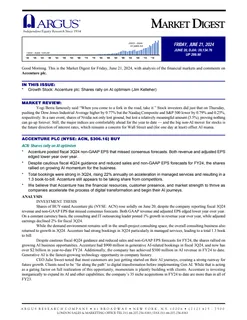
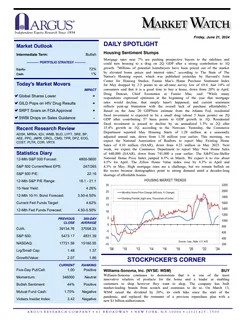
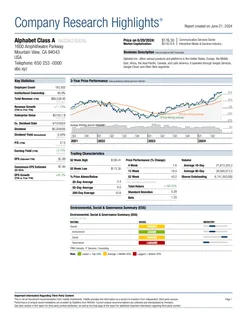
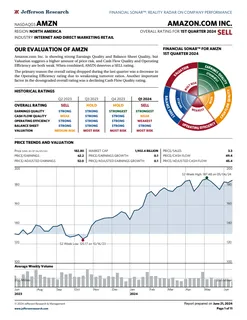
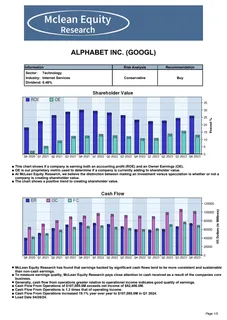
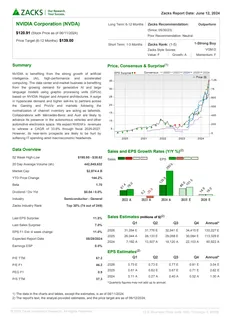

In [26]:
documents_t.show()

(Note: although Pixeltable updates `documents` and `chunks`, it **does not** automatically update the `queries` table. This is by design: we don't want all rows in `queries` to get automatically re-executed every time a single new document is added to the document base. However, newly-added rows will be run over the new, incrementally-updated index.)

To confirm that the `chunks` index got updated, we'll re-run the chunks retrieval query for the question

```What is the expected EPS for Nvidia in Q1 2026?```

Previously, our most similar chunk had a similarity score of ~0.81. Let's see what we get now:

In [27]:
nvidia_eps_query.collect()

similarity,text
0.858,"15.39%. Expanding Portfolio Aids Prospects In the fiscal first quarter, NVIDIA launched the Blackwell platform targeted for AI computing at a trillion-parameter scale and the Blackwell￾powered DGX SuperPOD for Generative AI supercomputing. It announced NVIDIA Quantum and NVIDIA Spectrum X800 series switches for InfiniBand and Ethernet, respectively, optimized for trillion￾parameter GPU computing and AI infrastructure. Moreover, the company launched NVIDIA AI Enterprise 5.0 with NVIDIA NIM in ...... l EPS (TTM) 1.80 Zacks Equity Research www.zacks.com Page 5 of 10optimizations and integrations for Windows to deliver maximum performance on NVIDIA GeForce RTX AI PCs and workstations. For the Professional Visualization domain, it launched NVIDIA RTX 500 and 1000 professional Ada generation laptop GPUs for AI-enhanced workflows, NVIDIA RTX A400 and A1000 GPUs for desktop workstations and NVIDIA Omniverse Cloud APIs. Operating Details NVIDIA's non-GAAP gross margin increased to 78.9% from 66"
0.856,".8% in the year-ago quarter and 76.7% from the previous quarter, mainly driven by higher Data Center sales. Non-GAAP operating expenses increased 43% year over year and 13.2% sequentially to \$2.50 billion. The increase was due to higher compensations and related benefits. However, as a percentage of total revenues, non-GAAP operating expenses declined to 9.6% from 24.3% in the year-ago quarter and 30.7% in the previous quarter. The non-GAAP operating income was \$18.06 billion compared with \$ ...... nd marketable securities were \$31.44 billion, up from \$25.98 billion as of Jan 28, 2024. As of Apr 28, 2024, the total long-term debt was \$8.46 billion, unchanged sequentially. NVIDIA generated \$15.4 billion in operating cash flow, up from the previous quarter's \$11.5 billion. The company ended the fiscal first quarter with a free cash flow of \$14.94 billion. In the fiscal first quarter, it returned \$7.8 billion to shareholders through dividend payouts and share repurchases. Guidance For the"
0.848,"from outside the United States. Sales revenues to customers outside the United States accounted for more than 56% of the total revenues for fiscal 2024. Hence, we believe that any unfavorable currency fluctuation and an uncertain macroeconomic environment may moderate the company's growth. Zacks Equity Research www.zacks.com Page 4 of 10Last Earnings Report NVIDIA Q1 Earnings Top Estimates, Revenues Rise Y/Y NVIDIA reported first-quarter fiscal 2025 earnings of \$6.12 per share, which beat t ...... 8%. NVIDIA is riding on a strong and innovative portfolio, with the growing adoption of its GPUs. It benefits from a strong partner base that includes the likes of TSMC, Synopsys, AWS, Alphabet, Microsoft, Oracle, and Johnson & Johnson MedTech. NVIDIA also announced a ten-for-one forward stock split of its issued common stock and raised the quarterly cash dividend by 150%. Segment Details NVIDIA reports revenues under two segments — Graphics, and Compute & Networking. Graphics accounted for"
0.847,"Q2 Q3 Q4 Annual* 2026 0.73 E 0.73 E 0.77 E 0.81 E 3.04 E 2025 0.61 A 0.62 E 0.67 E 0.71 E 2.62 E 2024 0.11 A 0.27 A 0.40 A 0.52 A 1.30 A *Quarterly figures may not add up to annual. 1) The data in the charts and tables, except the estimates, is as of 06/11/2024. 2) The report's text, the analyst-provided estimates, and the price target are as of 06/12/2024. Zacks Report Date: June 12, 2024 © 2024 Zacks Investment Research, All Rights Reserved 10 S. Riverside Plaza Suite 1600 · Chicago, IL 6 ...... the worldwide leader in visual computing technologies and the inventor of the graphic processing unit, or GPU. Over the years, the company's focus has evolved from PC graphics to artificial intelligence (AI) based solutions that now support high performance computing (HPC), gaming and virtual reality (VR) platforms. NVIDIA's GPU success can be attributed to its parallel processing capabilities supported by thousands of computing cores

Our most similar chunk now has a score of ~0.86 and pulls in more relevant chunks from the newly-inserted documents.

Let's recompute the `response` column of the `queries` table, which will automatically recompute the `answer` column as well.

In [28]:
queries_t.recompute_columns('response')

Inserting rows into `queries`: 8 rows [00:00, 915.86 rows/s]


8 rows updated, 16 values computed.

As a final step, let's confirm that all the queries now have answers:

In [29]:
queries_t.select(
    queries_t.Question,
    queries_t.correct_answer,
    queries_t.answer
).show()

Question,correct_answer,answer
What is the overall latest rating for Amazon.com from analysts?,SELL,"The provided passages do not contain any specific information or ratings regarding Amazon.com. They primarily focus on Alphabet Class A (GOOGL) and summarize the opinions of various research firms regarding its performance and projections. To find the latest rating for Amazon.com, you would need to consult a different source that provides analysis or recommendations specifically for Amazon.com."
What is the expected EPS for Nvidia in Q1 2026?,0.73 EPS,"The passages provided do not contain information regarding Nvidia's expected EPS for Q1 2026. They primarily focus on research highlights and financial data related to Alphabet (GOOGL) and other general market information. Therefore, I cannot provide an answer to the question regarding Nvidia's EPS."
What is roughly the current mortage rate?,0.07,The current mortgage rate is near 7%.
What is the market capitalization of Alphabet?,\$2182.8 Billion,"The market capitalization of Alphabet is \$2,182.8 billion."
What is the operating cash flow of Amazon in Q1 2024?,"18,989 Million","The provided passages do not contain any information about Amazon's operating cash flow for Q1 2024. Therefore, it is not possible to answer that question based on the contents of the provided passages."
What is the current dividend yield for Alphabet Inc. (\$GOOGL)?,0.0046,"The provided passages do not contain any information about Alphabet Inc.'s (\$GOOGL) current dividend yield. It focuses on equity summary scores, analyst recommendations, market capitalization, price, valuation ratios, and other financial statistics, but there is no mention of dividends or a dividend yield. Therefore, I cannot provide the current dividend yield for Alphabet Inc. based on the given content."
What are the main reasons to buy Nvidia?,"Datacenter, GPUs Demands, Self-driving, and cash-flow","The passages provided do not specifically discuss reasons to buy Nvidia. They primarily focus on Alphabet Inc. (GOOGL) and Accenture PLC (ACN), as well as general investment reporting and analyst opinions. If you are looking for investment reasons specific to Nvidia, additional sources focusing on Nvidia’s performance, market conditions, technological advancements, and analyst recommendations would be necessary."
What are the latest financial metrics for Accenture PLC?,missed consensus forecasts and strong total bookings rising by 22% annually,"As of fiscal 3Q24 (ended May 31, 2024), the latest financial metrics for Accenture PLC are as follows: - Revenue: \$16.47 billion, down 1% year over year. - GAAP gross margin: 33.4%, compared to 30.9% in 2Q24 and 33.4% a year earlier. - GAAP operating margin: 16.0%, compared to 13.0% in 2Q24 and 14.2% a year earlier. - Non-GAAP operating margin: 16.4%, compared to 13.7% in 2Q24 and 16.4% a year earlier. - Non-GAAP earnings per diluted share: \$3.13, down 2% year over year, and missed the consensus forecast of \$3.15. - FY23 revenue: Record revenue of \$64.1 billion, up 4% on a GAAP basis. - Cash: \$5.54 billion at the end of 3Q24, down from \$9.05 billion at the end of FY23. - Cash flow from operations in FY23: \$9.52 billion, with free cash flow forecasted for FY24 at \$8.7-\$9.3 billion. Accenture's financial strength ranking is High, with a long-term credit rating of Aa3 from Moody's and A+ from Standard & Poor's."
